# Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
---

## COVID-19 Canada Forecast of Cases and Deaths

- Daily forecast (in figure): predicting daily numbers (the following 28 daily numbers)

- Weekly forecast (in figure): predicting weekly numbers directly (the following 4 weekly numbers)

- Weekly report (in table): 4 total numbers for 4 weeks, each week is from StartDate to Date

- weekday: Mon = 1, Tue = 2, ..., Sun = 7


Data source: [OxCGRT Data](https://github.com/OxCGRT/covid-policy-tracker/tree/master/data)

Author: Jianfei Zhang (jianfei.zhang@ualberta.ca)

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
def load_OxCGRT():
    path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    d = pd.read_csv(path, parse_dates=['Date'], low_memory=False)
    d[['CountryName', 'RegionCode']] = d[['CountryName', 'RegionCode']].fillna('')
    d['Cases'], d['Deaths'] = d.ConfirmedCases.fillna(0), d.ConfirmedDeaths.fillna(0)
    d['Date'] = pd.to_datetime(d['Date'], format='%m/%d/%y')
    return d

In [3]:
def get_df(d, CountryName, RegionCode = ''):
    d = d[(d['CountryName'] == CountryName) & (d['RegionCode'] == RegionCode)].copy()
    # get weekday column, weekday: Mon=1, Tue=2, ...., Sun=7 
    d["weekday"] = d['Date'].dt.dayofweek + 1    
    d = d.set_index(['CountryName', 'RegionCode', 'weekday', 'Date'])   
    return d

In [4]:
d = load_OxCGRT()
d_CA = get_df(d, 'Canada')
d_exog = get_df(d, 'United States')

## Directive Multi-step Forecast

In [5]:
def daily_report(df, target_, predictions_, end_weekday, date_col, weekday, pred_steps):
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta(i+1) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted'+target_: predictions_}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col, weekday])
    df_merge = df[[target_]].join(df_forecast[['Predicted'+target_]], how='outer')
    df_merge.index = df_merge.index.droplevel(['CountryName', 'RegionCode', 'weekday'])
    df_merge.plot(title = 'Daily New ' + target_, figsize=(8,3), lw=1, style = '.-')
    plt.show()
    df_forecast = df_forecast.cumsum()
    df_forecast = df_forecast[df_forecast.index.get_level_values(weekday) == end_weekday].fillna(0)
    first_week = df_forecast['Predicted'+target_].iloc[0]
    df_forecast = df_forecast.diff()
    df_forecast['Predicted'+target_].iloc[0] = first_week
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('(StartDate through Date) Weekly New ' + target_ + ' (via Daily Prediction):\n')
    display(df_forecast.round(0).astype('int32'))

def daily_forecast(d, target, end_weekday = 5, date_col = 'Date', weekday = 'weekday', pred_steps = 28):
    df = d[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df.diff().fillna(0)
    #df_exog = d_exog[[target[0]]].copy()
    #df_exog = df_exog.loc[df_exog[target[0]].ne(0)]
    #df_exog = df_exog.diff().fillna(0)
    train = df.values
    #train_exog = df_exog.values
    model = VARMAX(train, order = (5,0))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=pred_steps)
    daily_report(df, target[0], predictions[:,0], end_weekday, date_col, weekday, pred_steps)
    daily_report(df, target[1], predictions[:,1], end_weekday, date_col, weekday, pred_steps)

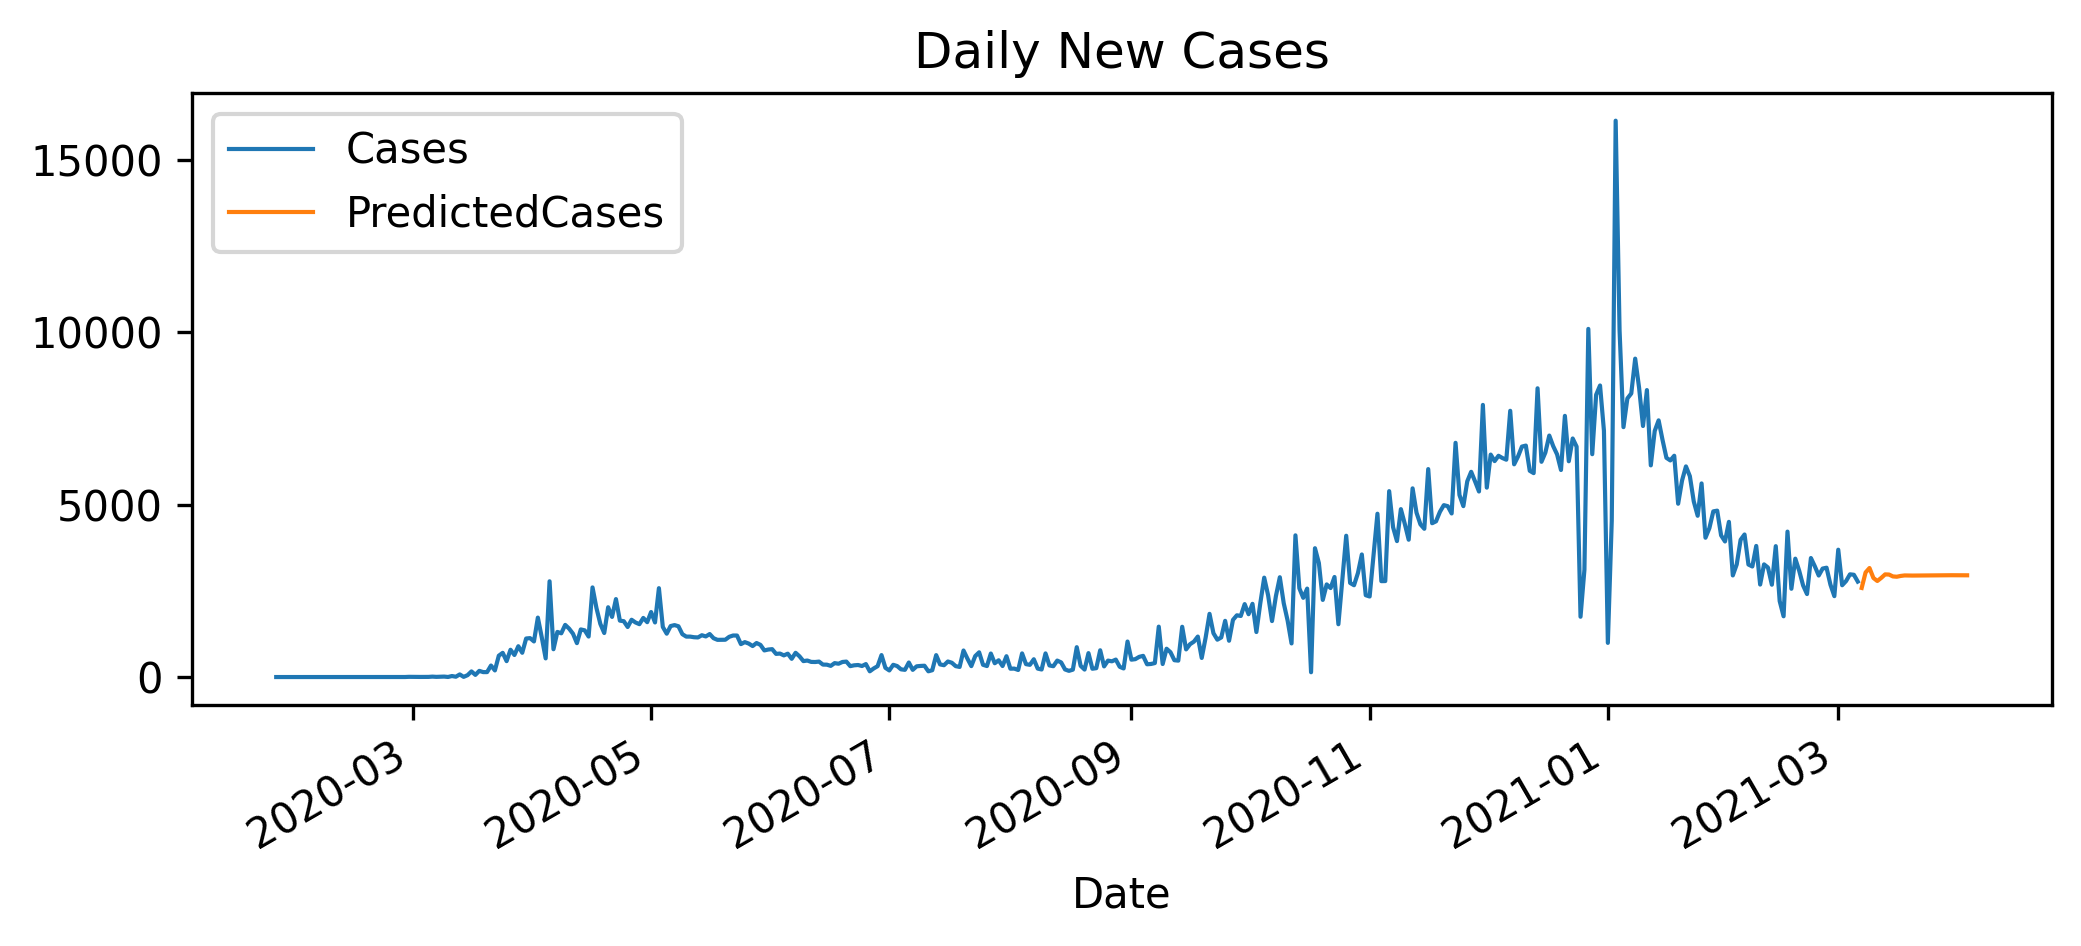

(StartDate through Date) Weekly New Cases (via Daily Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,11656
2021-03-17,3,2021-03-10,20375
2021-03-24,3,2021-03-17,20627
2021-03-31,3,2021-03-24,20670


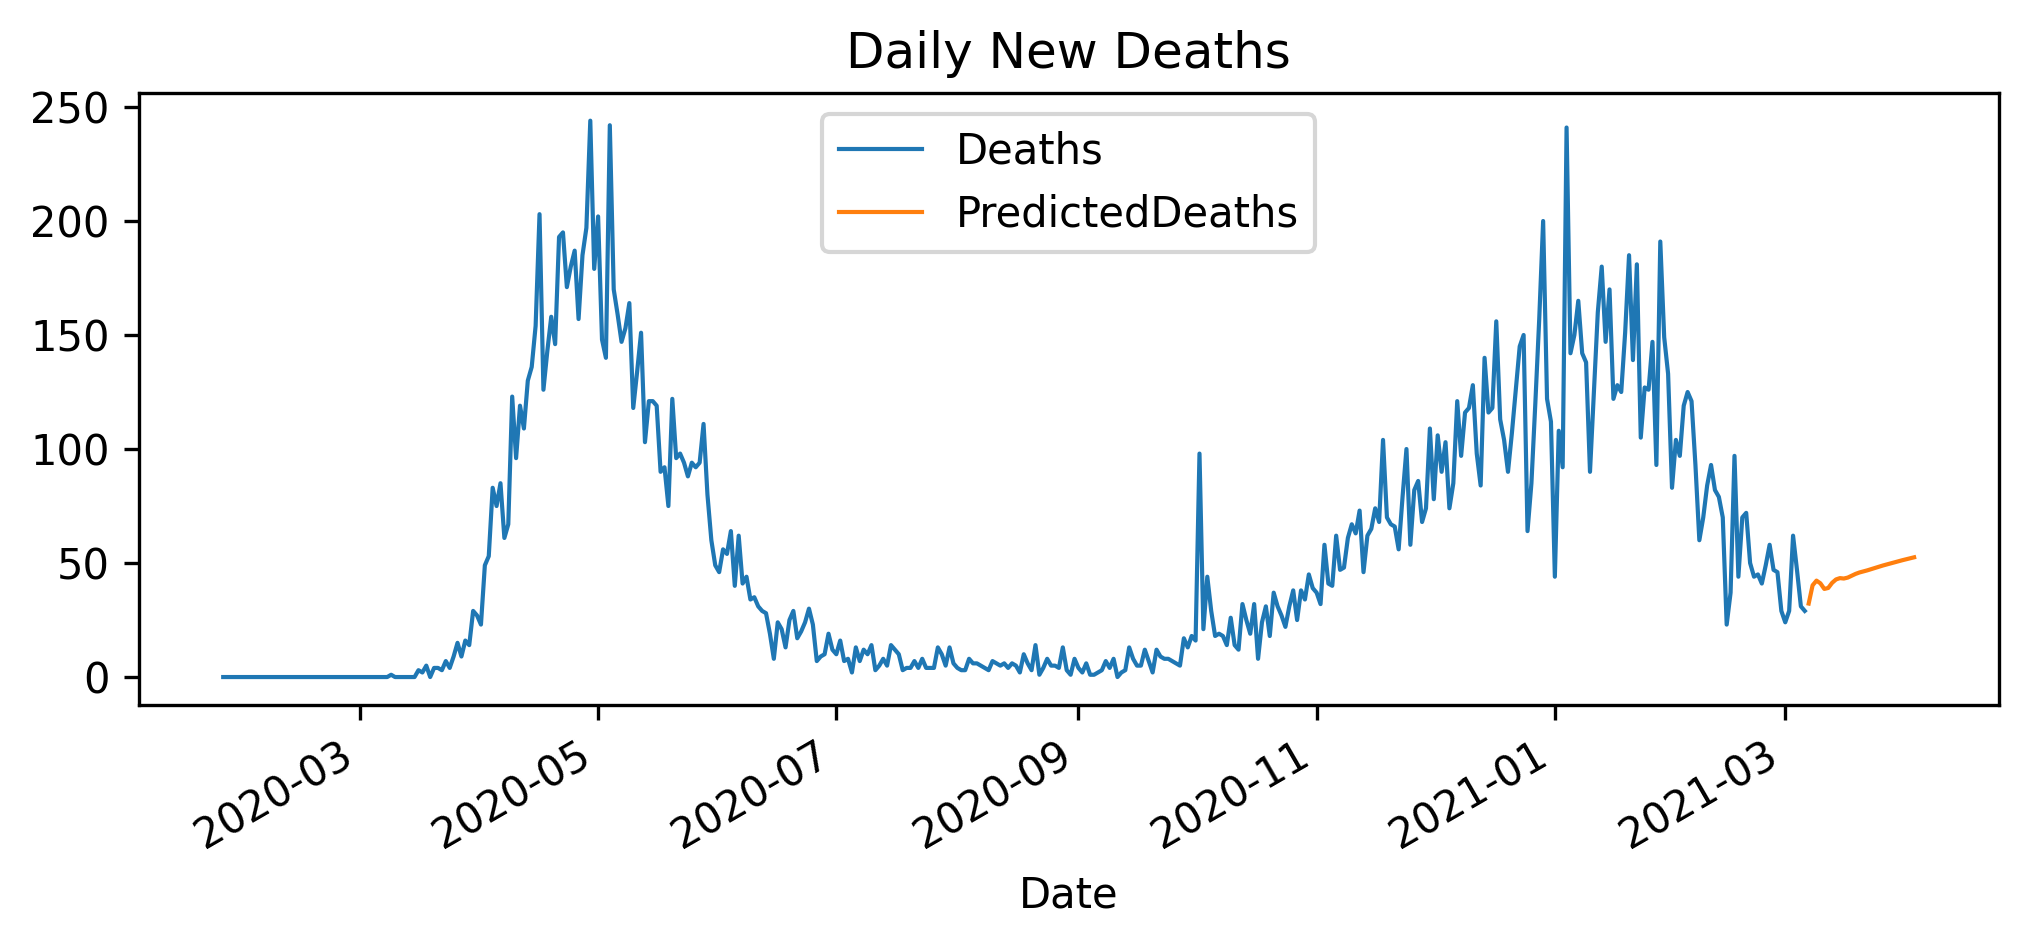

(StartDate through Date) Weekly New Deaths (via Daily Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,156
2021-03-17,3,2021-03-10,292
2021-03-24,3,2021-03-17,324
2021-03-31,3,2021-03-24,349


In [6]:
daily_forecast(d_CA, ['Cases', 'Deaths'], 5)

In [7]:
def weekly_report(df, target_, predictions_, end_weekday, date_col, weekday, pred_steps, interval):
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta((i+1)*interval) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted' + target_: predictions_}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col,weekday])
    df_merge = df[[target_]].join(df_forecast[['Predicted'+target_]], how='outer')
    df_merge.index = df_merge.index.droplevel(['CountryName', 'RegionCode', 'weekday'])
    df_merge.plot(title = 'Weekly New ' + target_, figsize=(8,3), lw=1, style = '.-')
    plt.show()
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('(StartDate through Date) Weekly New ' + target_ + ' (via Weekly Prediction):\n')
    display(df_forecast.round(0).astype('int32'))
 
    
    
def weekly_forecast(d, target, end_weekday = 5, date_col = 'Date', weekday = 'weekday', pred_steps = 4, interval = 7):
    df = d[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df[df.index.get_level_values(weekday) == end_weekday].fillna(0)
    df = df.diff().fillna(0)
    train = df.values
    model = VARMAX(train, order = (2,0))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=pred_steps)
    weekly_report(df, target[0], predictions[:,0], end_weekday, date_col, weekday, pred_steps, interval)
    weekly_report(df, target[1], predictions[:,1], end_weekday, date_col, weekday, pred_steps, interval)

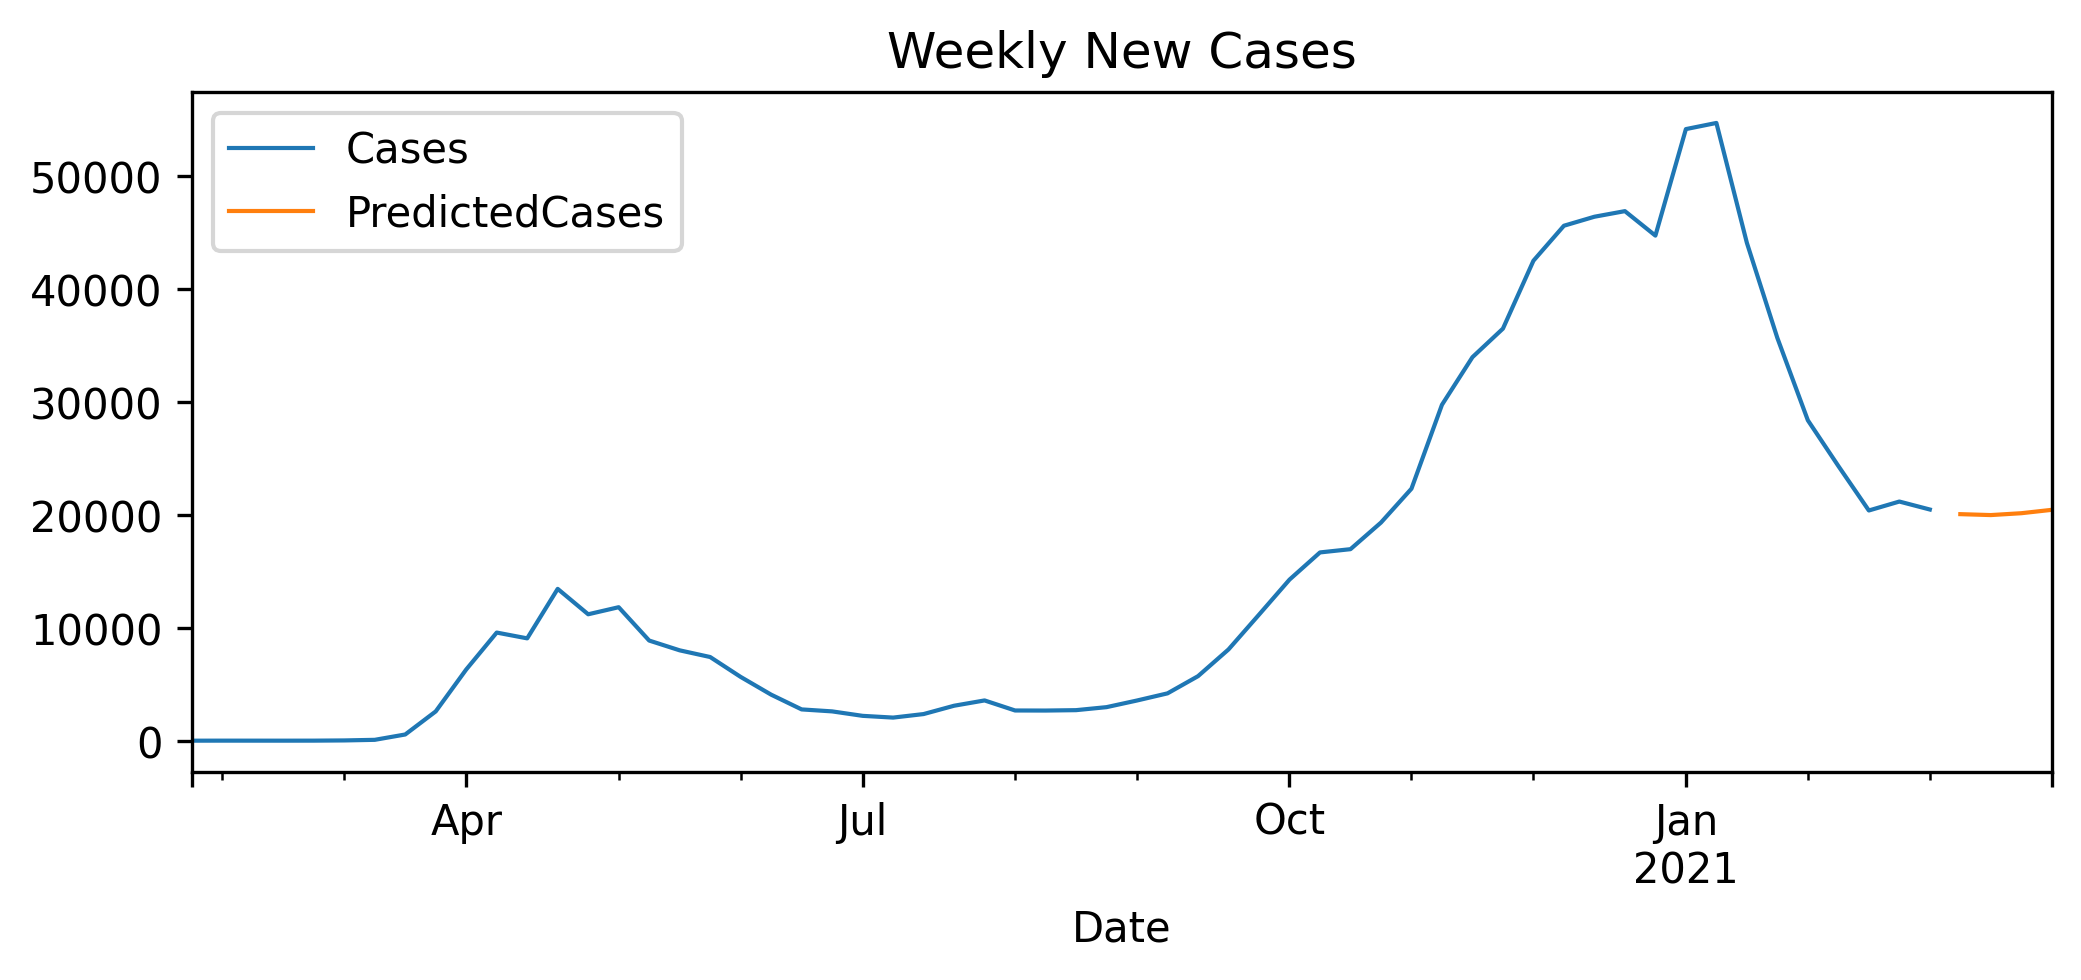

(StartDate through Date) Weekly New Cases (via Weekly Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,20076
2021-03-17,3,2021-03-10,19994
2021-03-24,3,2021-03-17,20158
2021-03-31,3,2021-03-24,20458


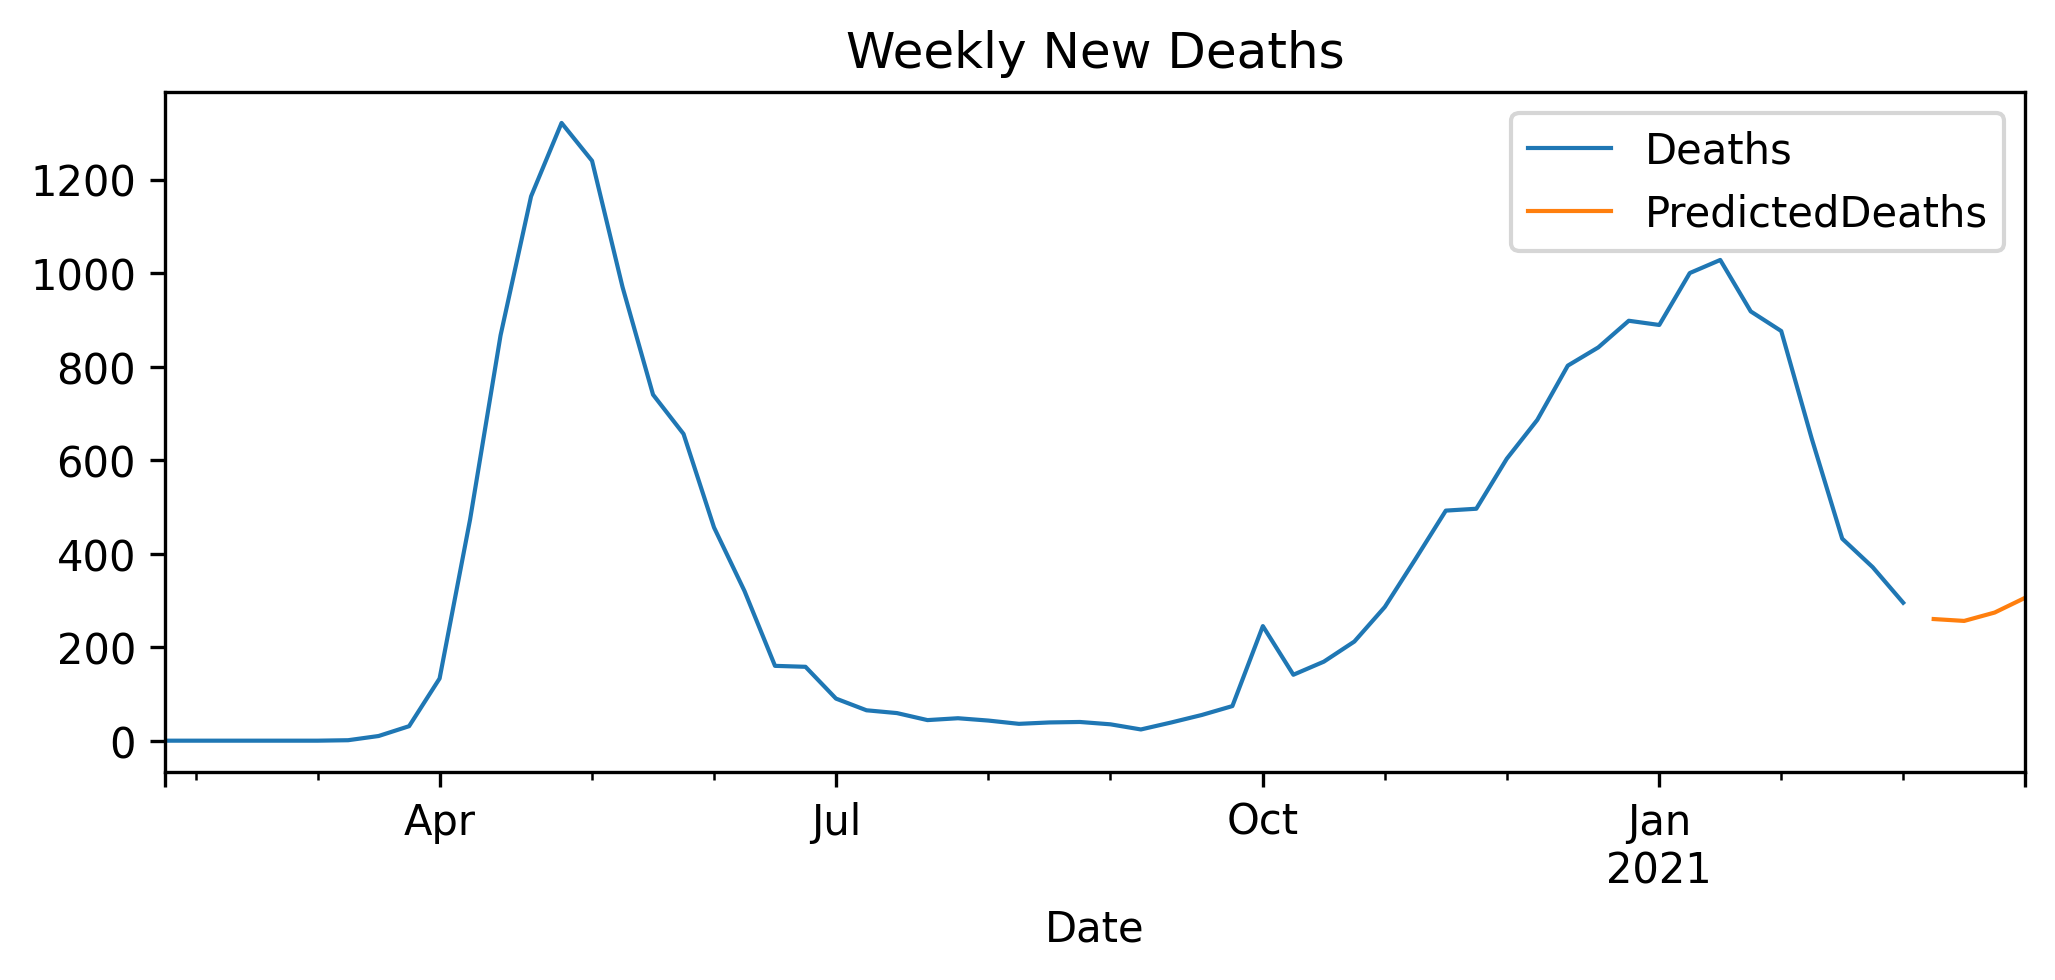

(StartDate through Date) Weekly New Deaths (via Weekly Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,260
2021-03-17,3,2021-03-10,256
2021-03-24,3,2021-03-17,274
2021-03-31,3,2021-03-24,306


In [8]:
weekly_forecast(d_CA, ['Cases', 'Deaths'], 5)